In [51]:
import pandas as pd

user_hist_df = pd.read_csv('../data/raw/movies_dataset_10 months.csv')
user_hist_df['ts'] = pd.to_datetime(user_hist_df['ts'])
user_hist_df['month'] = user_hist_df['ts'].dt.month

test_1 = user_hist_df[user_hist_df['month'] == 6]
test_2 = user_hist_df[user_hist_df['month'] == 7]
train = user_hist_df[~user_hist_df['month'].isin([6, 7])]

In [53]:
user_hist_df = train.drop(['episode_id', 'ts'], 1).drop_duplicates()

In [4]:
user_hist_df['val'] = 1
interact = pd.pivot(user_hist_df, 'user_id', 'movie_id', 'val').fillna(0)

In [5]:
interact.shape

(2055, 4843)

In [6]:
user_corr = interact.corr()

In [9]:
import matplotlib.pyplot as plt

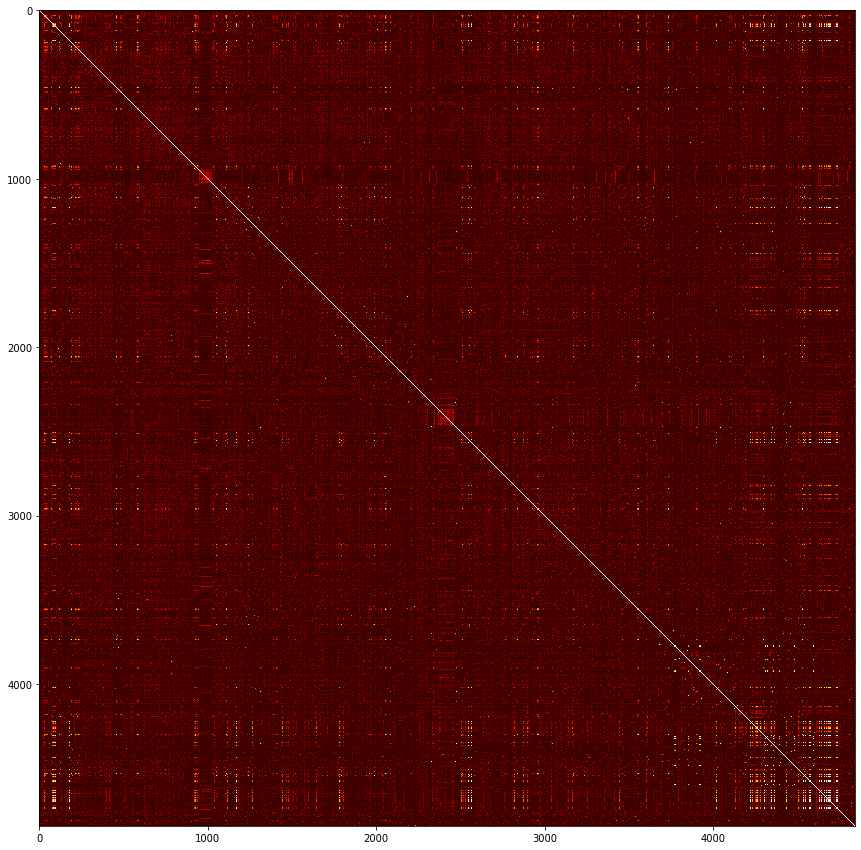

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(user_corr,cmap='hot',interpolation='nearest');

# covisits

In [54]:
user_hist_df = pd.read_csv('../data/raw/movies_dataset_10 months.csv')
user_hist_df = user_hist_df[user_hist_df['episode_id'] == 0]
user_hist_df['ts'] = pd.to_datetime(user_hist_df['ts'])
user_hist_df['month'] = user_hist_df['ts'].dt.month

test_1 = user_hist_df[user_hist_df['month'] == 6]
test_2 = user_hist_df[user_hist_df['month'] == 7]
train = user_hist_df[~user_hist_df['month'].isin([6, 7])]

train = train[['user_id', 'movie_id']].drop_duplicates()

In [55]:
correct_1 = test_1.drop_duplicates(['user_id', 'movie_id']).groupby('user_id')['movie_id'].apply(list).to_dict()
correct_2 = test_2.drop_duplicates(['user_id', 'movie_id']).groupby('user_id')['movie_id'].apply(list).to_dict()



In [56]:
user_hist = train.groupby('user_id')['movie_id'].apply(set).to_dict()

In [59]:
import ml_metrics as metrics

In [73]:
covis = {}

for user in user_hist:
    curr_user_hist = user_hist[user]
    for film in curr_user_hist:
        if covis.get(film):
            for other in curr_user_hist:
                if other == film:
                    continue
                else:
                    if covis[film].get(other):
                        covis[film][other] += 1
                    else:
                        covis[film][other] = 1
        else:
            covis[film] = {}
            for other in curr_user_hist:
                if other == film:
                    continue
                else:
                    if covis[film].get(other):
                        covis[film][other] += 1
                    else:
                        covis[film][other] = 1
            

In [74]:
covis_full = covis.copy()

In [75]:
for film in covis:
    covis[film] = dict(sorted(covis[film].items(), key = itemgetter(1), reverse = True)[:30]) 
    total = sum(covis[film].values())
    for f in covis[film]:
        covis[film][f]/=total

In [76]:
from operator import itemgetter 



In [77]:
def pred_for_user(covis, user_hist, user, N):
    recoms = {}
    for film in user_hist[user]:
        cov = covis[film]
        for rec in cov:
            if recoms.get(rec):
                recoms[rec] += covis[film][rec]
            else:
                recoms[rec] = covis[film][rec]
    N_2 = N + 50
    res = dict(sorted(recoms.items(), key = itemgetter(1), reverse = True)[:N_2]) 
    
    res_f = list(set(res.keys()).difference(user_hist[user]))[:N]
    return res_f



In [78]:
recoms = {}
num_to_recom = 5
for user in correct_1.keys():
    rec = pred_for_user(covis, user_hist, user, 5)
    recoms[user] = rec
    if len(rec)<5:
        print(user)

metrics.mapk(list(recoms.values()), list(correct_1.values()), 5)

11254796898083103047


0.011409337676438655

In [79]:
recoms = {}
num_to_recom = 5
for user in correct_2.keys():
    rec = pred_for_user(covis, user_hist, user, 5)
    recoms[user] = rec
    if len(rec)<5:
        print(user)

metrics.mapk(list(recoms.values()), list(correct_2.values()), 5)

11254796898083103047


0.012804404145077723